In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

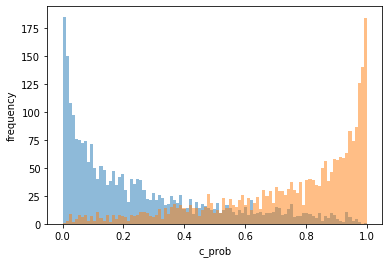

x has shape (5000, 30) 

coefficient values:
 0.0    9
 0.4    8
-0.4    8
-0.8    3
-1.2    1
 0.8    1
dtype: int64 

c has shape (5000,) 

c values
0    2505
1    2495
dtype: int64 



In [2]:
# simulate condition c as a function of covariates x

n_features = 30
n_examples = 5000

x = np.random.randn(n_examples, n_features)
xc_coeffs = .4 * np.round(np.random.randn(n_features))
c_logits = np.squeeze(x @ xc_coeffs[:, np.newaxis])

def logistic(x): return 1 / (1 + np.exp(-1 * x))

c_prob = logistic(c_logits)
c = (np.random.rand(n_examples) < c_prob).astype(int)

plt.hist(c_prob[c == 0], bins=np.linspace(0, 1, 100), alpha=.5)
plt.hist(c_prob[c == 1], bins=np.linspace(0, 1, 100), alpha=.5)
plt.xlabel('c_prob')
plt.ylabel('frequency')
plt.show()

print('x has shape', np.shape(x), '\n')
print('coefficient values:')
print(pd.value_counts(xc_coeffs), '\n')
print('c has shape', np.shape(c), '\n')
print('c values')
print(pd.value_counts(c), '\n')

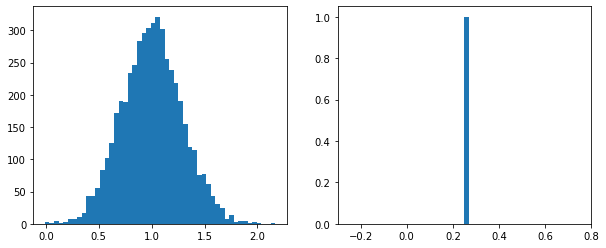

In [3]:
# simulate event times as a function of c and x with uniform censoring

max_time = 10

xmu_coeffs = .05 * np.round(np.random.randn(n_features))
mu_event = np.squeeze(1 + (x @ xmu_coeffs[:, np.newaxis]))

#xsigsq_coeffs = .02 * np.round(np.random.randn(n_features))
#sigsq_event = np.squeeze(x @ xsigsq_coeffs[:, np.newaxis])

sigsq_event = .25

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(mu_event, bins=50)
ax[1].hist(sigsq_event, bins=50)
plt.show()

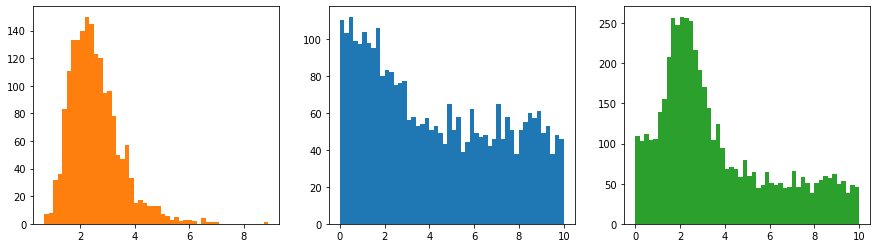

In [4]:
event_times = np.exp(mu_event + sigsq_event * np.random.randn(n_examples)) + max_time * (1 - c)
censoring_times = max_time * np.random.rand(n_examples)

t = np.minimum(event_times, censoring_times)
s = (t == event_times).astype(int)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].hist(t[s == 1], color='C1', bins=50)
ax[1].hist(t[s == 0], color='C0', bins=50)
ax[2].hist(t, color='C2', bins=50)
plt.show()

In [5]:
import sys
sys.path.append('../src')
from model import CFTModel

In [6]:
mdl = CFTModel(c_layer_sizes=())
with tf.Session() as sess:
    mdl.train(sess, x, t[:, np.newaxis], s[:, np.newaxis], 200, learning_rate=1e-3)
    c_pred = mdl.predict_c(sess, x)
    c_weights = mdl.get_c_weights(sess)

Initial Values:
nloglik = -3.80e+09
log_p(t, s | x, c = 1): -7.54e+00
log_p(t, s | x, c = 0): -3.60e+09
t_mu: -6.55e-03 t_sig: 5.00e-01

Completed Epoch 0
nloglik = -3.95e+09
log_p(t, s | x, c = 1): -7.84e+00
log_p(t, s | x, c = 0): -3.60e+09
t_mu: -2.38e-02 t_sig: 5.00e-01

Completed Epoch 10
nloglik = -5.71e+09
log_p(t, s | x, c = 1): -1.25e+01
log_p(t, s | x, c = 0): -3.60e+09
t_mu: -2.17e-01 t_sig: 5.00e-01

Completed Epoch 20
nloglik = -7.86e+09
log_p(t, s | x, c = 1): -2.17e+01
log_p(t, s | x, c = 0): -3.60e+09
t_mu: -4.56e-01 t_sig: 5.00e-01

Completed Epoch 30
nloglik = -1.02e+10
log_p(t, s | x, c = 1): -3.68e+01
log_p(t, s | x, c = 0): -3.60e+09
t_mu: -7.32e-01 t_sig: 5.00e-01

Completed Epoch 40
nloglik = -1.27e+10
log_p(t, s | x, c = 1): -5.79e+01
log_p(t, s | x, c = 0): -3.60e+09
t_mu: -1.03e+00 t_sig: 5.00e-01

Completed Epoch 50
nloglik = -1.52e+10
log_p(t, s | x, c = 1): -8.51e+01
log_p(t, s | x, c = 0): -3.60e+09
t_mu: -1.33e+00 t_sig: 5.00e-01

Completed Epoch 60
nlogl

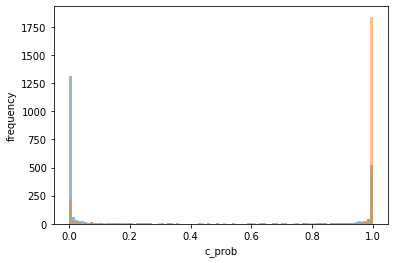

In [7]:
plt.hist(c_pred[c == 0], bins=np.linspace(0, 1, 100), alpha=.5)
plt.hist(c_pred[c == 1], bins=np.linspace(0, 1, 100), alpha=.5)
plt.xlabel('c_prob')
plt.ylabel('frequency')
plt.show()

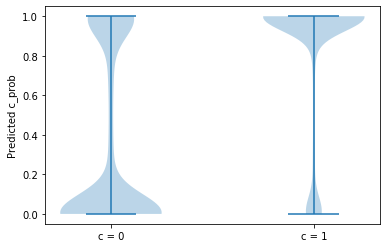

In [8]:
plt.violinplot([c_pred[c == 0], c_pred[c == 1]])
plt.xticks([1, 2], ['c = 0', 'c = 1'])
plt.ylabel('Predicted c_prob')
plt.show()

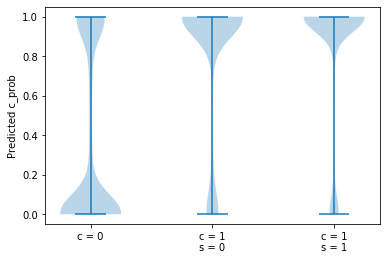

In [12]:
plt.violinplot([c_pred[c == 0], c_pred[(c == 1) & (s == 0)], c_pred[(c == 1) & (s == 1)]])
plt.xticks([1, 2, 3], ['c = 0', 'c = 1\ns = 0', 'c = 1\ns = 1'])
plt.ylabel('Predicted c_prob')
plt.show()

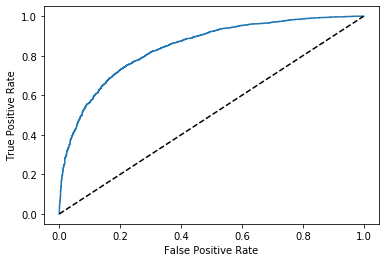

AUC = 0.84


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(c, c_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print('AUC = %.2f' % roc_auc_score(c, c_pred))

# Issues

- nature of penalty. is there a more principled way to choose this?
- when using NN, it will predict everyone is positive (to avoid penalty, presumably)
- dealing with variance of lognormal distribution

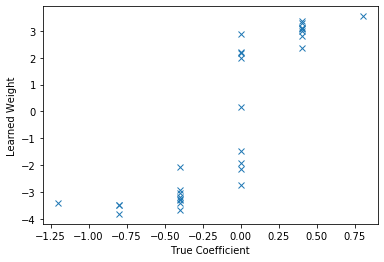

In [10]:
plt.plot(xc_coeffs, c_weights, 'x')
plt.xlabel('True Coefficient')
plt.ylabel('Learned Weight')
plt.show()